In [1]:
import pymc as pm
import numpy as np
import arviz as az

# 5. Meta-analysis via Hierarchical Models*

Adapted from [Unit 7: rats_nocentering.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/rats_nocentering.odc).


This example is taken from Gelfand et al. (1990) and concerns 30 young rats whose weights were measured weekly for five weeks.  Measurements were taken at 8, 15, 22, 29, and 36 days.

The observed weights (in grams) for each rat are arranged in the matrix $\mathbf{Y}$, where $y_{i,j}$ is the weight of the $i$-th rat at age $x_j$. The first two and last rows of $\mathbf{Y}$ are shown below:

<div align = 'center'>

| Rat | $y_{i,8} $ | $ y_{i,15} $ | $ y_{i,22} $ | $ y_{i,29} $ | $ y_{i,36} $ |
|-----|:-------------:|:--------------:|:--------------:|:--------------:|:--------------:|
|  1  |     151       |     199        |     246        |     283        |     320        |
|  2  |     145       |     199        |     249        |     293        |     354        |
| ... |     ...       |     ...        |     ...        |     ...        |     ...        |
| 30  |     153       |     200        |     244        |     286        |     324        |

</div>

Each row corresponds to a different rat ($ i = 1, \ldots, 30 $), and each column corresponds to one of the five measurement times.



Data for $x$ can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/rats_nocenteringx.txt), and $\mathbf{Y}$ [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/rats_nocenteringY.txt).

A hierarchical model lets us model each rat's growth curve as a linear function of age, while also allowing the intercept (baseline weight) and slope (growth rate) to vary across rats. This structure essentially "borrowing strength" across units in a meta-analysis.  It allows us to estimate both group-level (population) and individual-level effects.

The model is defined as:

$$
\begin{align}
y_{ij} &\sim \mathcal{N}(\mu_{ij}, \sigma^2)\\
\mu_{ij} &= \alpha_i + \beta_i x_j\\
\alpha_i \sim &\mathcal{N}(\mu_{\alpha}, \tau_{\alpha}^{-1}) \\
\beta_i \sim &\mathcal{N}(\mu_{\beta}, \tau_{\beta}^{-1})\\
\alpha_i &\sim \mathcal{N}(\mu_{\alpha}, \tau_{\alpha}^{-1}) \\
\beta_i &\sim \mathcal{N}(\mu_{\beta}, \tau_{\beta}^{-1})\\
\mu_{\alpha} &\sim \mathcal{N}(0, 10^6) \\
\tau_{\alpha} &\sim \text{Gamma}(0.001, 0.001) \\
\mu_{\beta} &\sim \mathcal{N}(0, 10^6) \\
\tau_{\beta} &\sim \text{Gamma}(0.001, 0.001) \\
\tau &\sim \text{Gamma}(0.001, 0.001) \\
\sigma &= \tau^{-1/2}
\end{align}
$$

 - Line 1-2 are the likelihood
 - Lines 3 and 4 are the Random Effects
 - Lines 7-12 are Hyperpriors

We will use a `graphviz` below to verify that we've specifed out model correctly.  This is particularly useful in models with complex hierarchical structures.

In [2]:
y = np.loadtxt("../data/rats_nocenteringy.txt")
x = np.loadtxt("../data/rats_nocenteringx.txt")
x.shape, y.shape

((5,), (30, 5))

In [3]:
with pm.Model() as m:
    mu_alpha = pm.Normal("mu_alpha", 0, tau=1e-6)
    tau_alpha = pm.Gamma("tau_alpha", 0.001, 0.001)
    mu_beta = pm.Normal("mu_beta", 0, tau=1e-6)
    tau_beta = pm.Gamma("tau_beta", 0.001, 0.001)

    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    alpha = pm.Normal("alpha", mu_alpha, tau=tau_alpha, shape=(30, 1))
    beta = pm.Normal("beta", mu_beta, tau=tau_beta, shape=(30, 1))

    mu = alpha + beta * x
    pm.Normal("y", mu, tau=tau, observed=y)

    trace = pm.sample(3000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, tau_alpha, mu_beta, tau_beta, tau, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.


In [4]:
az.summary(trace, var_names=["~alpha", "~beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,106.580,2.301,102.281,110.993,0.020,0.020,12945.0,8892.0,1.0
mu_beta,6.186,0.106,5.984,6.384,0.001,0.001,13349.0,9764.0,1.0
tau_alpha,0.010,0.004,0.004,0.017,0.000,0.000,9928.0,8287.0,1.0
tau_beta,4.308,1.477,1.889,7.028,0.014,0.019,11501.0,9832.0,1.0
tau,0.027,0.004,0.020,0.035,0.000,0.000,8516.0,9008.0,1.0
sigma,6.156,0.468,5.343,7.083,0.005,0.004,8516.0,9008.0,1.0


If you have not had any courses in Regression or Design and Analysis of Experiments, take a moment and research how to *interpret* these coefficients: especially `mu`'s  and `tau`'s.

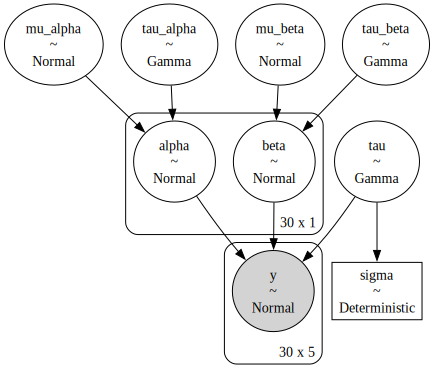

In [5]:
pm.model_to_graphviz(model=m)

In [6]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Thu Jun 12 2025

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.17.2

pytensor: 2.30.3

arviz: 0.21.0
numpy: 1.25.2
pymc : 5.22.0

